In [6]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [7]:
import numpy as np

import matplotlib.pyplot as plt

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from discopy import grammar
from discopy import Dim

from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter

In [8]:
BATCH_SIZE = 50
EPOCHS = 1000
SEED = 2

In [9]:
#Input data MC1
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [10]:
#we will use 15% of the data as a training set
labels, data = read_data('MC1.TXT')
train_labels, train_data = labels[0:15] , data[0:15]
test_labels, test_data = labels[15:100] , data[15:100]
print(train_data)
#print(train_labels) #incorrect

tag = []

#associate train_circuit to tags
food_keywords = ['chef','dish','meal','tasty','prepares']
code_keywords = ['programmer','code','hacker','writes']

positive_keywords = ['skilful','devoted','tasty','creates']

def label_data(train_data):
    tag = []

    for i in range(np.size(train_data)):
        words = [word for word in train_data[i].split()]
        for l in words:
            for j in food_keywords:
                if l == j:
                    a = 0

            for k in code_keywords:
                if l == k:
                    a = 1
            
            for h in positive_keywords:
                if l == h :
                    b = 1
                else:
                    b = 0
        
        tag.append([a,b])
    return tag


#rewrite training labels
train_labels = label_data(train_data)


['cook creates complicated dish', ' experienced chef prepares complicated dish', 'skilful programmer creates code', ' devoted hacker writes code', 'skilful cook creates meal', ' devoted hacker creates complicated code', 'hacker writes code', ' skilful hacker creates code', 'devoted hacker writes code', ' hacker writes complicated code', 'skilful programmer creates advanced code', ' skilful hacker writes complicated code', 'experienced cook prepares meal', ' experienced chef prepares meal', 'devoted programmer creates advanced code']


In [11]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [12]:
train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
test_diagrams = [
    diagram.normal_form()
    for diagram in test_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(test_diagrams, test_labels)
    if diagram is not None]

In [13]:
#Circuits
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

In [14]:
#render circuits
render_circuit_jupyter(train_circuits[14].to_tk())

In [15]:
#Model
all_circuits = train_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

#Training from diagrams
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [16]:
#Loss & eval metrics
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [17]:
#Trainer
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [18]:
#Create datasets
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [19]:
#Train model
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 2.8839   valid/loss: 1.9761   train/acc: 0.3333   valid/acc: 0.5765
Epoch 100:   train/loss: 0.1656   valid/loss: 2.2945   train/acc: 0.8333   valid/acc: 0.5294
Epoch 200:   train/loss: 0.0775   valid/loss: 1.5580   train/acc: 0.8333   valid/acc: 0.5412
Epoch 300:   train/loss: 0.0783   valid/loss: 1.4041   train/acc: 0.8333   valid/acc: 0.5412
Epoch 400:   train/loss: 0.0299   valid/loss: 1.0437   train/acc: 0.8667   valid/acc: 0.5529
Epoch 500:   train/loss: 0.0560   valid/loss: 1.4286   train/acc: 0.8333   valid/acc: 0.5412
Epoch 600:   train/loss: 0.0923   valid/loss: 1.7210   train/acc: 0.7667   valid/acc: 0.5235
Epoch 700:   train/loss: 0.0338   valid/loss: 2.0786   train/acc: 0.8333   valid/acc: 0.5059
Epoch 800:   train/loss: 0.0403   valid/loss: 1.8992   train/acc: 0.8667   valid/acc: 0.4941
Epoch 900:   train/loss: 0.0432   valid/loss: 2.5132   train/acc: 0.8333   valid/acc: 0.5000
Epoch 1000:  train/loss: 0.0205   valid/loss: 2.1197   train/acc: 0.83

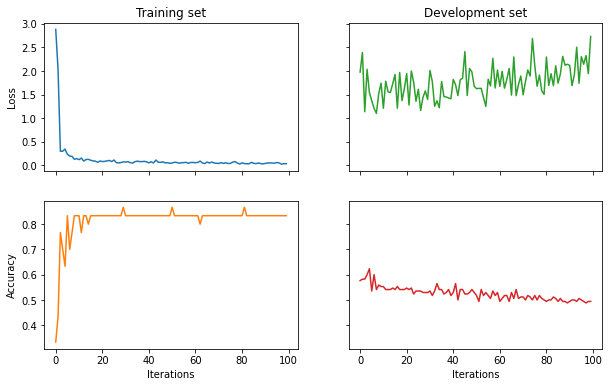

In [20]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))